In [1]:
# 필수 import
import numpy as np
import matplotlib.pyplot as plt

# Chapter 2 자연어와 단어의 분산 표현

이번 장에서 할 내용:
- 컴퓨터에게 말을 이해시키는 방법을 배워본다. 그 중에서도 딥러닝 등장 이전의 기법들
- 파이썬으로 텍스트를 다루는 연습도 같이 진행한다.

## 2.1 자연어 처리란

자연어(natural language): 우리가 평소에 쓰는 말
자연어 처리(Natural Language Processing, NLP): 자연어를 컴퓨터에게 이해시키기 위한 분야

대표적인 예시: 검색 엔진, 기계 번역, 질의응답 시스템, IME(입력기 전환), 문장 자동요약 등등(이것의 궁극적인 진화 버전이 chatGPT라고 보면 될 듯)

### 2.1.1 단어의 의미

'단어'는 의미의 최소 단위이다. '단어의 의미'를 컴퓨터에게 이해시키는 것이 중요하다.

이번 장과 다음 장을 거쳐서 다음 세 의미를 알아보고자 한다.
- thesaurus(유의어 사전)을 활용한 기법 (이번 장)
- 통계 기반 기법 (이번 장)
- 추론 기반 기법 (word2vec) (다음 장)


## 2.2 thesaurus

동의어를 그룹화해서 묶거나, 상위-하위, 전체-부분을 정의해놓기도 했다.

동의어 집합을 만든 다음, 단어들의 관계를 그래프로 표현해 단어 사이의 연결을 정의한다.

이 '단어 네트워크'를 이용해 컴퓨터에게 단어 사이의 관계를 가르쳤다.

WordNet은 thesaurus 연구로, 많은 연구와 다양한 자연어 처리 애플리케이션에 사용되고 있다.

thesaurus는 다음과 같은 문제점이 있다.
- 시대 변화에 대응하기 어렵다
- 사람을 쓰는 비용은 크다
- 단어의 미묘한 차이를 표현할 수 없다.

## 2.3 통계 기반 기법

통계 기반 기법에서는 말뭉치(corpus)를 이용한다. 통계 기반 기법의 목표는 말뭉치에서 자동으로, 효율적으로 feature를 추출하는 것이다.

### 2.3.1 파이썬으로 말뭉치 전처리하기

전처리(preprocessing)은 텍스트 데이터를 단어로 분할하고 그 분할된 단어들을 단어 ID 목록으로 변환하는 일이다.

In [2]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/util.py
License: MIT License
Accessed: 2024-11-19
------------------------------------------------------------
"""

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [3]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 2.3.2 단어의 분산 표현

'단어의 의미'를 정확하게 파악할 수 있도록 벡터 표현으로 나타낸 것이 단어의 분산 표현이다.

### 2.3.3 분포 가설

**분포 가설**은 '단어의 의미는 주변 단어에 의해 형성된다'라는 아이디어이다. 즉, 단어 자체에는 의미가 없고, 그 단어가 사용된 '맥락 context'이 의미를 형성한다는 것이다. 

여기서 맥락(context)는 주목하는 단어 주변에 놓인 단어를 의미한다.

### 2.3.4 동시발생 행렬

분포 가설에 기반해 단어를 벡터로 나타내는 방법을 생각해보자.

어떤 단어를 선택했을 때, 그 주변에 어떤 단어가 몇 번 등장했는지를 집계할 수 있다. 이를 일단 '통계 기반 기법'이라고 해보자.

문장을 우선 전처리 한다.

In [4]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


각 단어별로 주변에 어떤 단어가 있는지를 표로 나타내면 다음과 같다.

<img src="./deep_learning_2_images/fig 2-7.png" width="50%">

이 표의 이름을 **동시발생 행렬**이라고 부른다.

아래는 말뭉치로부터 동시발생 행렬을 구하는 걸 자동화한 파이썬 코드이다. 아래 코드는 말뭉치의 모든 단어 각각에 대해 주변 단어의 개수를 세아린다.

In [5]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/util.py
License: MIT License
Accessed: 2024-11-19
------------------------------------------------------------
"""

def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [6]:
co_matrix = create_co_matrix(corpus, len(word_to_id))
print(co_matrix)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


### 2.3.5 벡터 간 유사도

단어 벡터의 유사도를 나타내는 가장 좋은 방법은 cosine similarity이다. 

$$similarity(\mathbf{x}, \mathbf{y})={{\mathbf{x} \cdot \mathbf{y}}\over{||\mathbf{x}||||\mathbf{y}||}}$$

아래에는 각 벡터의 norm을 구하는데, 이때 norm은 L2 norm(벡터의 각 원소를 제곱해서 더한 뒤 제곱근 취하기)를 사용한다.

아래는 파이썬 코드로 작성한 cosine similarity이다.

In [7]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/util.py
License: MIT License
Accessed: 2024-11-19
------------------------------------------------------------
"""

def cos_similarity(x, y, eps=1e-8):
    '''코사인 유사도 산출

    :param x: 벡터
    :param y: 벡터
    :param eps: '0으로 나누기'를 방지하기 위한 작은 값
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [8]:
# 단어 간 유사도를 구하는 코드

"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch02/similarity.py
License: MIT License
Accessed: 2024-11-19

Modified to work in jupyter notebook
------------------------------------------------------------
"""

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]  # "you"의 단어 벡터
c1 = C[word_to_id['i']]    # "i"의 단어 벡터
print(cos_similarity(c0, c1))

0.7071067691154799


### 2.3.6 유사 단어의 랭킹 표시

아래 코드는 어떤 단어와 가장 유사한 단어를 순위별로 반환하는 `most_similar()` 함수이다. 

In [9]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/util.py
License: MIT License
Accessed: 2024-11-19
------------------------------------------------------------
"""

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [10]:
# argsort() 함수 설명
# argsort()는 np.array 속 원소를 오름차순으로 정렬한 다음, 정렬된 index를 반환한다.
x = np.array([100, -20, 2])
print(x.argsort())

[1 2 0]


In [11]:
# "you"를 검색어로 지정해 유사한 단어들을 출력함

"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch02/most_similar.py
License: MIT License
Accessed: 2024-11-19

Modified to work on jupyter notebook
------------------------------------------------------------
"""

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## 2.4 통계 기반 기법 개선하기

### 2.4.1 상호정보량

동시발생 행렬에서 "발생" 횟수는 좋은 feature는 아니다. "the car"라는 말이 많이 사용되지만 "the"와 "car"는 연관성이 크지 않기 때문이다. 

이를 개선하기 위해 **점별 상호정보량(Pointwise Mutual Informaion, PMI)**를 사용한다. PMI는 확률변수 $x$와 확률변수 $y$에 대해 다음과 같이 정의된다. 
$$PMI(x, y)=\log_2{{P(x,y)}\over{P(x)P(y)}}$$
$P(x), P(y)$는 x, y가 일어날 확률, $P(x,y)$는 x, y가 동시에 일어날 확률이다. PMI 값이 높을수록 두 확률변수 x, y 사이 관련성이 높다. 

이를 앞서 본 동시발생 행렬 $C$로 바꾸면, $C(x), C(y)$는 x와 y가 나타난 횟수, $C(x,y)$는 x와 y가 동시발생한 횟수이다. PMI를 $C$에 기반해 바꾸면 다음과 같다. 
$$PMI(x, y)=\log_2{{P(x,y)}\over{P(x)P(y)}}=\log_2{{C(x,y) \cdot N}\over{C(x)C(y)}}$$

PMI를 실제로 구현했을 때, 두 단어의 동시발생 횟수가 0이면 $\log_20$ 문제가 생기므로, Positive PMI(PPMI)를 정의해 사용한다.
$$PPMI(x,y)=\max(0, PMI(x,y))$$

In [12]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/util.py
License: MIT License
Accessed: 2024-11-19
------------------------------------------------------------
"""

def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI(점별 상호정보량) 생성

    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [13]:
# 동시발생 행렬을 PPMI 행렬로 변환하는 코드
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch02/ppmi.py
License: MIT License
Accessed: 2024-11-19

Modified to work on jupyter notebook
------------------------------------------------------------
"""

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


PPMI 행렬은 corpus의 어휘 수가 늘어날수록 각 단어 벡터의 차원수가 늘어난다는 문제점이 있다.

또한, 원소 대부분이 0의 값을 가지므로, 원소별 중요도가 낮고, 노이즈에 약하고 견고하지 못하다.

이에 대응하기 위한 개념이 dimensionality reduction이다.

### 2.4.2 차원 감소

**차원 감소(dimensionality reduction)** 는 중요한 정보를 최대한 유지하면서 벡터의 차원을 줄이는 기법이다. 

다음 그림은 차원 감소를 나타내는 그림이다.

<img src="./deep_learning_2_images/fig 2-8.png" width="60%">

차원 감소에 사용되는 방법 중 하나는 **특잇값분해(Singular Value Decomposition)** 를 사용한다.

SVD는 임의의 행렬을 세 행렬의 곱으로 분해한다. 

$$\mathbf{X}=\mathbf{U}\mathbf{S}\mathbf{V}^T$$

$\mathbf{U}$와 $\mathbf{V}$는 orthogonal matrix(직교행렬)이고, 열벡터는 서로 직교한다. $\mathbf{S}$는 대각행렬(diagonal matrix)이다. 

$\mathbf{U}$ 행렬을 '단어 공간'으로 생각한다. $\mathbf{S}$의 대각성분에는 특잇값(singular value)가 큰 순서대로 나열되어 있다. 특잇값은 '해당 축'의 중요도를 나타낸다. 따라서, 아래 그림처럼 중요하지 않은 부분인 뒷 부분을 깎아낸 행렬을 생각할 수 있다.

<img src="./deep_learning_2_images/fig 2-10.png" width="60%">

이를 단어 공간으로 바꾸면, $\mathbf{X}$의 각 행에는 해당 단어 ID의 단어 벡터가 저장되어 있고, 이들은 $\mathbf{U}'$라는 차원 감소된 벡터로 표현된다.

### 2.4.3 SVD에 의한 차원 감소

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 0.000e+00  3.409e-01 -1.205e-01 -3.886e-16 -9.323e-01  0.000e+00
 -1.086e-16]


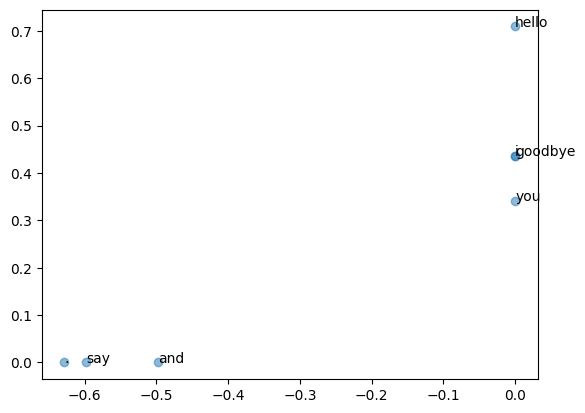

In [14]:
# SVD 차원 감소 코드
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch02/ppmi.py
License: MIT License
Accessed: 2024-11-19

Modified to work on jupyter notebook
------------------------------------------------------------
"""

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print(C[0])
print(W[0])
print(U[0])

# 플롯
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

### 2.4.4 PTB 데이터셋

**펜 트리뱅크(PTB)** 를 corpus로 이용해보자.

dataset/ptb.py를 저장해두어서 사용할 수 있도록 만들었다. 

In [15]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch02/show_ptb.py
License: MIT License
Accessed: 2024-11-19

Modified to work on jupyter notebook
------------------------------------------------------------
"""

from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


### 2.4.5 PTB 데이터셋 평가

빠른 SVD를 위해서는 `sklearn` 모듈을 설치하면 된다. (`sklearn` 모듈은 이전 이름으로, 지금은 `scikit-learn`을 설치하면 된다.)

In [16]:
# 느린 SVD: numpy SVD를 이용

"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch02/count_method_big.py
License: MIT License
Accessed: 2024-11-19

Modified to work on jupyter notebook
------------------------------------------------------------
"""

from dataset import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')

# numpy SVD
U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
calculating SVD ...

[query] you
 i: 0.700317919254303
 we: 0.6367185115814209
 anybody: 0.5

In [17]:
# 빠른 SVD: scikit-learn 모듈을 이용

"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch02/count_method_big.py
License: MIT License
Accessed: 2024-11-19

Modified to work on jupyter notebook
------------------------------------------------------------
"""

from dataset import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')

# numpy SVD
from sklearn.utils.extmath import randomized_svd
U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                         random_state=None)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
calculating SVD ...

[query] you
 i: 0.6967585682868958
 we: 0.6155701875686646
 'd: 0.59360

## 2.5 정리

컴퓨터에게 '단어의 의미'를 이해시키기 위해 thesaurus 기법을 먼저 보고, 통계 기반 기법을 살펴봤다.

thesaurus 기법은 사람의 수작업이 들어가서 매우 힘든 작업이 된다. 통계 기반 기법은 corpus에서 단어의 의미를 자동으로 추출하고, 그 의미를 벡터로 표현한다. 단어의 동시발생 행렬을 만들고, PPMI 행렬로 변환한 다음, SVD를 이용해 차원을 감소시켜 각 단어의 분산 표현을 만들어냈다. 그 결과 비슷한 단어들이 벡터 공간에서도 서로 가까이 모여있었다.